<a href="https://colab.research.google.com/github/ChristianKitte/DeepLearningWordPrediction/blob/main/Wortvorhersage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infos und Links

Interessante und für diese Arbeit genutzte Links

Keras API
https://keras.io/api/

Keras Embedding Layer
https://keras.io/api/layers/core_layers/embedding/

Grundlegende Arbeit
https://jaketae.github.io/study/auto-complete/

Dictionary Comprehensions
https://thispointer.com/python-how-to-convert-a-list-to-dictionary/

Rückgabe mehrerer Daten aus einer Funktion
https://www.delftstack.com/de/howto/python/return-multiple-values-python/

Rückgabeklassen in Python 
https://www.delftstack.com/de/howto/python/return-multiple-values-python/

Natural Language Toolkits (NLTK)
https://www.nltk.org/index.html.

Udemy Kurs
https://www.udemy.com/course/deep-learning-und-ai/learn/lecture/1524754#overview

Exportieren eines Keras bzw. Tensorflow Modells nach Tensorfllow.js 
https://www.tensorflow.org/guide/saved_model

# Laden aller Bibliotheken und notwendige Instanziierungen

In [5]:
# Tensorflow und Keras
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

# Matplotlib ist etwas aufwendiger
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# https://www.tensorflow.org/text/guide/tf_text_intro
!pip install -q "tensorflow-text==2.8.*"

# https://www.tensorflow.org/js/tutorials/conversion/import_keras
# Mit GPU !!!
!pip install tensorflowjs

#Installation von NLTK und SKLearn
!pip install nltk

import nltk
import sklearn

from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Wird für den word_tokenizer benötigt
nltk.download('punkt')

print("Fertig")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Fertig


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Diverse Importe
import os
import numpy as np

import tensorflow as tf
import tensorflowjs as tfjs
import tensorflow_datasets as tfds
import tensorflow_text as tftext

from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Flatten
from tensorflow.keras.utils import plot_model, to_categorical

print("Fertig")

Fertig


# Konfiguration

In [7]:
# Das verwendete File
FILE = "https://raw.githubusercontent.com/ryanmcdermott/trump-speeches/master/speeches.txt"
# Die zu verwendende Sequenz (Start und Ende)
USED_SEQUENCE_START = 0
USED_SEQUENCE_ENDE = 100000
# Wenn nicht None die Anzahl der zu verwendenden Top Tokens für die Codierung des Textes
TOP_FEATURE = None
# Die für das Training zu verwendende Länge des Fensters
SLICE_LENGTH = 3
# Input des neuronalen Netzes

# Allgemeine Funktionen und Variablen

In [8]:
def get_text():
  """

  Lädt die in FILE hinterlegte Datei herunter, legt sie lokal ab und gibt den
  bereinigten Inhalt zurück. Zeilenumbrüche werden herausgefiltert, Zeilen einem
  Trim unterzogen.

  """

  # Lädt die Datei herunter und gibt den Pfad der herunter geladenen Datei zurück
  text_dir = tf.keras.utils.get_file('speeches', FILE) 
  
  # Einlesend es Inhalts
  with open(text_dir, "r", encoding="utf-8") as file:
    contents = file.read()
    
  contents = contents.split("\n")
  contents = [line.strip() for line in contents if "SPEECH" not in line]

  contents = "\n".join(contents)

  # return contents
  return contents[USED_SEQUENCE_START:USED_SEQUENCE_ENDE+1]

print("Fertig")

Fertig


# Methoden für die Vorverarbeitung der Textdaten

In [9]:
def get_top_tokens(text):
  """

  Gibt die top_max_features Top Tokens des übergebenen Textes zurück. Default
  ist None.
  
  text - Der zu zerlegende Text

  """

  # Die im Text enthaltenen Wörter
  tokens = word_tokenize(text)

  # Convert a collection of text documents to a matrix of token counts.
  # Only consider the top max_features ordered by term frequency across the corpus.
  # (.*) sorgt dafür, dass Punkte beachtet werden
  cv = CountVectorizer(max_features=TOP_FEATURE, lowercase=False, token_pattern="(.*)")

  cv.fit(tokens)    
  
  return cv.get_feature_names_out()  

print("Fertig")

Fertig


In [10]:
# Wort als Key, Code als Value
word_to_int2={}
# Code als Key, Word als Value
int_to_word2={}

def set_dictionaries(features):
  """

  Erstellen einer eindeutigen Wordliste und Zuordnungslisten auf Basis der
  übergebenen features (Wortliste). Füllt zwei Dictionaries, die
  im weiteren Verlauf zur Codierung des Textes verwendet werden.
  
  features - Eine Liste der Features, welche Verwendung finden. In diesem 
  Kontext die Liste der berücksichtigten Wörter. 

  Wort als Key, Code als Value:
  word_to_int2={}
  Code als Key, Word als Value:
  int_to_word2={} 

  """

  word_to_int2.clear()
  int_to_word2.clear()

  for i in range(0, len(features)):
    word=features[i]

    word_to_int2[word]=i
    int_to_word2[i]=word

print("Fertig")


Fertig


In [11]:
def create_coded_token(features):
  """

  Wandelt die übergebenen features (Wörter) in eine Liste ihrer numerische 
  Entsprechung um. Hierfür werden zuvor erstellte Dictionaries verwendet.

  Wort als Key, Code als Value:
  word_to_int2={}
  Code als Key, Word als Value:
  int_to_word2={} 
  
  """
  
  coded_token = [word_to_int2[feature] for feature in features if feature in word_to_int2]

  return coded_token

print("Fertig")

Fertig


# Übersichten und grafische Ausgaben

Bei der Detailausgabe der ersten drei Features / Labels erkennt man, dass die Trainingsdaten wie gewollt aufgebaut sind. Das Label enthält hierbei immer das nächste Wort als Code.

In [12]:
def print_übersicht(npFeatures, npLabels):
  """

  Gibt eine Übersicht über den aktuellen Arrayinhalt der ersten drei Enträge
  der übergebenen Arrays aus.
  
  npFeatures, npLabels - Die aktuell gültigen Numpy Arrays

  """

  print("Übersicht über das Ergebnis: ")
  
  print(npFeatures[0])
  print(npLabels[0])
  print(npFeatures[1])
  print(npLabels[1])
  print(npFeatures[2])
  print(npLabels[2])

print("Fertig")

Fertig


In [13]:
def print_summary(model):
  """ 
  Druckt die Zusammenfassung des übergebenen Netzes aus

  model - Das zu nuztende Netz

  """
  
  print("")
  print("Textliche Übersicht der Modellstruktur:")
  model.summary()
  print("")

print("Fertig")

Fertig


# Trainingsdaten erzeugen

In [14]:
# Array mit den Feature Daten
features_tmp=[]
# Array mit den Label Daten
labels_tmp=[]

def split_training_data(coded_token):
  """

  Teilt die übergebenen und kodierten Texttoken in Feature- und Labellisten auf.
  Gesteuert wird die Aufteilung durch die Sequenzlänge SLICE_LENGT. Das Ergebnis
  wird in den Arrays features_tmp und labels_tmp hinterlegt.
  
  coded_token - Der in Token zerlegte und codierte Text

  """

  features_tmp.clear()
  labels_tmp.clear()

  for i in range(0, len(coded_token)-SLICE_LENGTH):
    features_tmp.append(coded_token[i:i+SLICE_LENGTH]) # bei Python inkl:exl
    labels_tmp.append(coded_token[i+SLICE_LENGTH]) 
  
print("Fertig")

Fertig


In [15]:
def create_trainings_data():
  """

  Lädt den aktuellen Text herunter, bereitet ihn auf und zerlegt ihn für das 
  Training. Die Schrittgröße und Anzahl der berücksichtigten Features wird 
  über die Voreinstellungen gesteuert.
  
  """

  # Text holen und den gesamten Text in Stringtoken zerlegen
  text=get_text()
  text_token= word_tokenize(text)

  # Features gemäß den Einstellungen in der Konfiguration besorgen
  features = get_top_tokens(text)
  
  # Dictionaries auf Basis der features erstellen
  set_dictionaries(features)

  # Ausgabe als Test
  print("")
  print("Ausgabe der Text Token:")
  print(text_token)
  print(len(text_token))

  # Codieren des Trainingstextes auf Basis der zuvor erstellten Dictionieries
  training_data=create_coded_token(text_token)

  # Ausgabe als Test
  print("")
  print("Ausgabe der Trainingsdaten (vercodeter Text):")
  print(training_data)
  print(len(training_data))

  # Splitten der Daten und sliden auf Basis der in der Konfiguration 
  # hinterlegten Schrittlänge um die features_tmp und labels_tmp zu füllen
  split_training_data(training_data)

print("Fertig")

Fertig


# Neuronales Netz erzeugen und trainieren

In [16]:

def create_model(input_dim_top_feature):
  """

  Erzeugen des zu verwendenden Models mit Hilfe der Keras Bibliothek. Es wird
  die Dimension der verwendeten TopFeatures für den Embedded Layer übergeben.

  input_dim_top_feature - Die Dimension der verwendeten Features. Diese sind für 
  die korrekte Konfiguration des Embedded Layers notwendig.
  
  """
  
  model=Sequential()

  # https://keras.io/api/layers/core_layers/embedding/
  # size input (Vokabular/Top Features), size output (Dense embedding), 
  # Sequenzelänge (da erster Layer) 
  model.add(Embedding(input_dim_top_feature,150,input_length=SLICE_LENGTH))

  model.add(LSTM(128, return_sequences=True)) # Es folgt ein LSTM
  model.add(LSTM(128, return_sequences=False)) # letztes LSTM

  model.add(Dense(200,activation="sigmoid"))
  model.add(Dense(200,activation="sigmoid"))
  model.add(Dense(200,activation="sigmoid"))
  model.add(Dense(200,activation="sigmoid"))
  #model.add(Dense(input_dim_top_feature,activation="sigmoid"))
  #model.add(Dense(input_dim_top_feature,activation="sigmoid"))

  # https://www.youtube.com/watch?v=qx8l-LmdgEk
  model.add(Dense(input_dim_top_feature, activation="softmax"))

  # https://www.tensorflow.org/api_docs/python/tf/keras/metrics/categorical_crossentropy
  # https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

print("Fertig")

Fertig


In [17]:
def train_model(model, input_dim_top_feature, npFeatures, npLabels, epochen, batch):
  """

  Trainiert das übergebene Model aud Basis der Vorgaben

  model - Das zu nutzende Modell
  input_dim_top_feature - Die Dimension der verwendeten Features 
  npFeatures - Die aktuellen Features für das Training 
  npLabels Die aktuellen Labels für das Training 
  epochen -  Gibt die Anzahl der Epochen an 
  batch - Gibt die Größe des Batches an
  
  """

  # Model trainieren
  model.fit(npFeatures,to_categorical(npLabels,num_classes=input_dim_top_feature), epochs=epochen, batch_size=batch)

print("Fertig")

Fertig


# Speichern und exportieren

In [20]:
def save():
  """

  Speichert das aktuell definierte und trainierte Modell temporär als:
  ./tfjs_model/model ab
  
  """
  #tf.saved_model.save(model, "./tf/modell")
  #model.save('./mein/h5/model.h5')
  tfjs.converters.save_keras_model(model, "./tfjs_model/model")

  print("Fertig")

save()

Fertig


In [22]:
import json

def create_word_list():
  """

  Erzeugt aus der aktuellen Int zu Token Zuordnung ein JSON und speichert dies 
  als: ./tfjs_model/words/words.json ab.

  """
  
  l= [value for key, value in int_to_word2.items()]

  with open("./tfjs_model/words/words.json","w",encoding="utf-8") as file:
    file.write(json.dumps(l))

  print("Fertig")

create_word_list()

Fertig


# Beginn der direkten Nutzung der zuvor definierten Methoden

In [18]:
len(word_to_int2)

0


Ausgabe der Text Token:
['...', 'Thank', 'you', 'so', 'much', '.', 'That', "'s", 'so', 'nice', '.', 'Is', "n't", 'he', 'a', 'great', 'guy', '.', 'He', 'does', "n't", 'get', 'a', 'fair', 'press', ';', 'he', 'does', "n't", 'get', 'it', '.', 'It', "'s", 'just', 'not', 'fair', '.', 'And', 'I', 'have', 'to', 'tell', 'you', 'I', "'m", 'here', ',', 'and', 'very', 'strongly', 'here', ',', 'because', 'I', 'have', 'great', 'respect', 'for', 'Steve', 'King', 'and', 'have', 'great', 'respect', 'likewise', 'for', 'Citizens', 'United', ',', 'David', 'and', 'everybody', ',', 'and', 'tremendous', 'resect', 'for', 'the', 'Tea', 'Party', '.', 'Also', ',', 'also', 'the', 'people', 'of', 'Iowa', '.', 'They', 'have', 'something', 'in', 'common', '.', 'Hard-working', 'people', '.', 'They', 'want', 'to', 'work', ',', 'they', 'want', 'to', 'make', 'the', 'country', 'great', '.', 'I', 'love', 'the', 'people', 'of', 'Iowa', '.', 'So', 'that', "'s", 'the', 'way', 'it', 'is', '.', 'Very', 'simple', '.', 'With', 

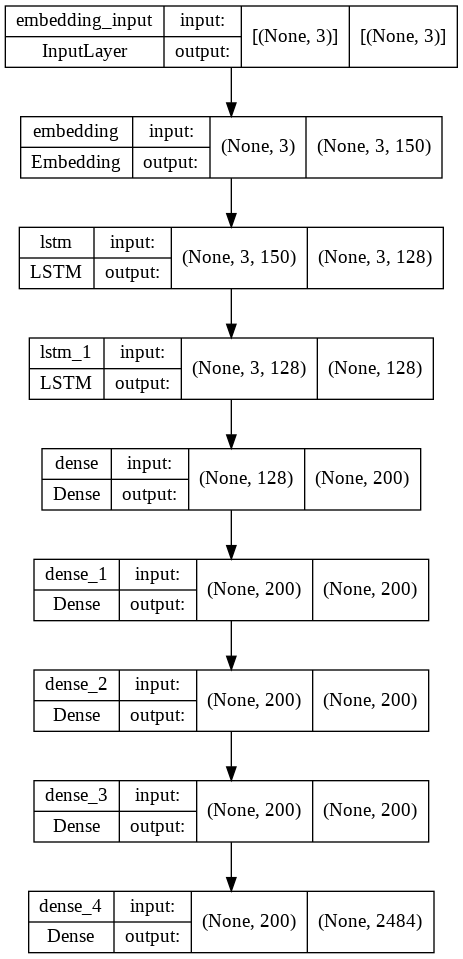

In [19]:
# Trainigsdaten neu erzeugen
create_trainings_data()

# Numpy Arrays erzeugen
npFeatures=np.array(features_tmp)
npLabels=np.array(labels_tmp)

# Kontrollausgabe der ersten drei Einträge von Feature und Label
print("")
print("Übersicht Feature und Labels 0 bis 2:")
print_übersicht(npFeatures,npLabels)

# Kontrollausgabe der ersten drei Einträge von Feature und Label
print("")
print("Übersicht Länge der Zuordnungstabelle:")
print(len(word_to_int2))

# Erstellen des neuronalen Netzes
model=create_model(len(word_to_int2))

# Übersichten ausgeben
print("")
print("Übersicht des neuronalen Netzes:")
model.summary()

# Trainieren des Netzes
x=npFeatures.size
train_model(model, len(word_to_int2), npFeatures, npLabels, 100, 32)

print("")
print("Struktur des neuronalen Netzes:")
tf.keras.utils.plot_model(
  model,
  show_shapes=True,
  show_layer_names=True,
)